<a href="https://colab.research.google.com/github/ammobam/Study_DeepLearing/blob/main/210820_Pytorch_GAN_%EC%8A%A4%ED%83%80%EC%9D%BC%EC%A0%84%EC%9D%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ** Generative Model (생성모델)

## Style Transfer (스타일 전이)
- 콘텐츠에 스타일의 특성을 추가해서 새로운 이미지를 만들어내는 모델

### 데이터 가져오기

#### 라이브러리 import

In [ ]:
# Pytorch 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim

import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms

# 이미지 출력
import matplotlib.pyplot as plt
from PIL import Image

#### 하이퍼파라미터 설정

In [ ]:
# 하이퍼 파라미터 설정

# 컨텐츠의 손실 비율 설정
content_layer_num = 1

# 이미지 사이즈
image_size = 512

# 훈련 횟수
epochs = 5000

#### 데이터 불러오기

In [ ]:
# 이미지 경로
content_dir = '/content/drive/MyDrive/data/GAN/cake.jpg'
style_dir = '/content/drive/MyDrive/data/GAN/yosigo.jpg'

# 확인
content = Image.open(content_dir)
print(content.size)
style = Image.open(style_dir)
print(style.size)

(900, 1260)
(1080, 1350)


### 데이터 전처리/후처리 함수

#### 이미지 전처리 함수
- Normalize 시, mean = [0.1, 0.1, 0.1]값을 줌에 따라 이미지의 밝기가 달라짐

In [ ]:
# 이미지 전처리 함수

# 이미지의 경로를 입력 받아서
def image_preprocess(img_dir):

    # 이미지 열고
    img = Image.open(img_dir)
    # 이미지 전처리 객체 만들고
    transform = transforms.Compose([
                                    transforms.Resize(image_size),
                                    transforms.CenterCrop(image_size),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.2, 0.2, 0.2],
                                    #transforms.Normalize(mean = [0.5, 0.5, 0.5],
                                                         # 0.4076392, 0.45795686, 0.4850196
                                                         std = [1,1,1])
    ])

    # 이미지에 전처리 객체 수행해서
    ### 컬러 이미지니까 전체(-1)에 대해 3개 채널 처리
    img = transform(img).view((-1, 3, image_size, image_size))
    # 이미지 텐서 리턴
    return img

In [ ]:
# 전처리 수행
content_img = image_preprocess(content_dir)
style_img = image_preprocess(style_dir)

print(type(content_img))
print(type(style_img))

<class 'torch.Tensor'>
<class 'torch.Tensor'>


#### 이미지 후처리 함수

In [ ]:
# 이미지 후처리 함수

# 텐서를 입력받으면
def image_postprocess(tensor):
    # 정규화 객체 만들고
    transform = transforms.Normalize(mean = [-0.2, -0.2, -0.2],
    #transform = transforms.Normalize(mean = [0.5,0.5,0.5],
                                     # 0.4076392, 0.45795686, 0.4850196
                                     std = [1,1,1])
    # 텐서를 복제하여 정규화함 : -1과 0 사이로
    img = transform(tensor.clone())
    # img의 데이터 값이 0보다 작으면 0으로, 1보다 크면 1로 바꿈
    img = img.clamp(0, 1) #??
    # 자리 바꾸기....
    img = torch.transpose(img, 0, 1)
    img = torch.transpose(img, 1, 2)
    
    # 이미지를 리턴
    return img

##### 함수의 이해.... 공부
- torch.clamp : https://aigong.tistory.com/178
- img.clamp(0, 1)
    - img의 데이터 값이
        - 0보다 작으면 0으로
        - 1보다 크면 1로 바꿈


In [ ]:
print("원래 텐서")
print("\t-", content_img.min())
print("\t-", content_img.max())
transform = transforms.Normalize(mean = [0.3, 0.3, 0.3],
                                     # 0.4076392, 0.45795686, 0.4850196
                                     std = [1,1,1])
print("정규화한 텐서")
print("\t-", transform(content_img.clone()).min())
print("\t-", transform(content_img.clone()).max())

원래 텐서
	- tensor(-0.4000)
	- tensor(0.6000)
정규화한 텐서
	- tensor(-0.7000)
	- tensor(0.3000)


In [ ]:
# clamp
img = transform(content_img.clone())
print(img) # 원본데이터가 전부 minus 값이라 clamp 처리하면 전부 0인 행렬이 만들어짐....
            # 그래서 정규화 평균값 바꿔줌
print(img.clamp(0, 1).max()) # 0
print(img.clamp(0, 1).min()) # 0

tensor([[[[ 0.1627,  0.1627,  0.1627,  ...,  0.0686,  0.0686,  0.0686],
          [ 0.1627,  0.1627,  0.1627,  ...,  0.0529,  0.0451,  0.0451],
          [ 0.1627,  0.1627,  0.1627,  ...,  0.0412,  0.0333,  0.0333],
          ...,
          [-0.0176, -0.0137, -0.0059,  ..., -0.0804, -0.0804, -0.0804],
          [-0.0216, -0.0176, -0.0098,  ..., -0.0843, -0.0804, -0.0804],
          [-0.0255, -0.0216, -0.0176,  ..., -0.0843, -0.0804, -0.0804]],

         [[ 0.1431,  0.1431,  0.1431,  ..., -0.1118, -0.1000, -0.1000],
          [ 0.1431,  0.1431,  0.1431,  ..., -0.1353, -0.1314, -0.1314],
          [ 0.1431,  0.1431,  0.1431,  ..., -0.1588, -0.1549, -0.1549],
          ...,
          [-0.0765, -0.0725, -0.0647,  ..., -0.2216, -0.2216, -0.2216],
          [-0.0804, -0.0765, -0.0686,  ..., -0.2255, -0.2216, -0.2216],
          [-0.0843, -0.0804, -0.0765,  ..., -0.2255, -0.2216, -0.2216]],

         [[ 0.1314,  0.1314,  0.1314,  ..., -0.2843, -0.2569, -0.2569],
          [ 0.1314,  0.1314,  

### 전이 모델 가져오기

#### 전이모델 가져오기

In [ ]:
# 전이모델 가져오기
resnet = models.resnet50(pretrained=True)

# 모델 구조 확인
for name, module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


#### 기존의 resnet 모델을 이용하는 새로운 모델을 생성
- 기존 모델의 층 구성
    - conv1ㅤㅤㅤㅤㅤㅤㅤㅤㅤ-> layer0
    - bn1 /relu /maxpoolㅤㅤㅤ-> layer1
    - layer1ㅤㅤㅤㅤㅤㅤㅤㅤㅤ-> layer2
    - layer2ㅤㅤㅤㅤㅤㅤㅤㅤㅤ-> layer3
    - layer3ㅤㅤㅤㅤㅤㅤㅤㅤㅤ-> layer4
    - layer4ㅤㅤㅤㅤㅤㅤㅤㅤㅤ-> layer5
    - avgpool /fcㅤㅤㅤㅤㅤㅤㅤ-> 출력층은 안 가져옴

In [ ]:
# 전이학습 모델에서 층 가져오기
class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()

        # Resnet의 레이어마다 결과값을 가져오도록 설정함
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])

    def forward(self, x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        return out_0, out_1, out_2, out_3, out_4, out_5

#### 그람 행렬화 클래스 생성

In [ ]:
# 그람 행렬화 클래스
class GramMatrix(nn.Module):
    def forward(self, input_):
        # 입력 텐서의 값을 분해하여 저장함
        b, c, h, w = input_.size()
        # 3차원으로 변경함
        F = input_.view(b, c, h * w)
        # 전치 행렬과의 내적을 구하고 더함       (bmm ??)
        G = torch.bmm(F, F.transpose(1, 2))
        return G

In [ ]:
#help(torch.bmm)

#### 손실을 계산하는 클래스 생성

In [ ]:
# 손실 계산 클래스
class GramMSELoss(nn.Module):
    def forward(self, input_, target):
        out = nn.MSELoss()(GramMatrix()(input_), target)
        return out

#### 디바이스 설정

In [ ]:
# Colab GPU를 켜고 확인해보면 True가 나옴
print("GPU 사용가능 여부:", torch.cuda.is_available())

# 디바이스 설정
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('torch version:', torch.__version__)
print('DEVICE:', DEVICE)

GPU 사용가능 여부: False
torch version: 1.9.0+cu102
DEVICE: cpu


#### 기존 모델의 파라미터를 수정하지 않도록 설정
- 기존 모델은 resnet의 이미지를 학습하여 가중치를 설정한 상태임
- 전이학습 모델을 이용하여 style 이미지를 contents에 적용하고자 함
    - 기존 모델의 가중치를 그대로 사용함
    - 우린 훈련 이미지도 없음...
- 전이학습으로 분류를 수행하는 경우,
    - 우리가 가진 이미지를 모델에 학습시켜서 사용해야 함

In [ ]:
# 기존 모델의 파라미터를 수정하지 않도록 설정
resnet = Resnet().to(DEVICE)

# 이 모델을 이용해서 스타일을 컨텐츠에 적용할 예정
# 이 모델을 이용해서 분류 작업을 하는 경우, True로 설정해야 함
for param in resnet.parameters():
    param.requires_grad = False

### 컨텐츠 및 스타일 이미지 설정

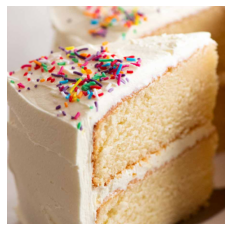

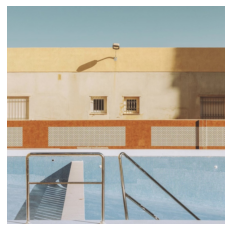

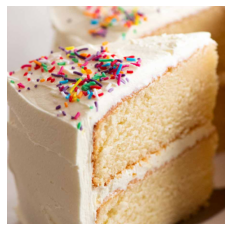

In [ ]:
# 전처리 시 mean 값을 0.1로 준 경우 ..
content = image_preprocess(content_dir).to(DEVICE)
style = image_preprocess(style_dir).to(DEVICE)
generated = content.clone().requires_grad_().to(DEVICE)
    ## ?????

# 각각 시각화
# 컨텐츠
plt.imshow(image_postprocess(content[0]).to(DEVICE))
plt.axis("off")
plt.show()

plt.imshow(image_postprocess(style[0]).to(DEVICE))
plt.axis("off")
plt.show()

plt.imshow(image_postprocess(generated[0]).to(DEVICE).data.numpy())
plt.axis("off")
plt.show()

In [ ]:
help(torch.Tensor.requires_grad_)
# Change if autograd should record operations on this tensor


Help on method_descriptor:

requires_grad_(...)
    requires_grad_(requires_grad=True) -> Tensor
    
    Change if autograd should record operations on this tensor: sets this tensor's
    :attr:`requires_grad` attribute in-place. Returns this tensor.
    
    :func:`requires_grad_`'s main use case is to tell autograd to begin recording
    operations on a Tensor ``tensor``. If ``tensor`` has ``requires_grad=False``
    (because it was obtained through a DataLoader, or required preprocessing or
    initialization), ``tensor.requires_grad_()`` makes it so that autograd will
    begin to record operations on ``tensor``.
    
    Args:
        requires_grad (bool): If autograd should record operations on this tensor.
            Default: ``True``.
    
    Example::
    
        >>> # Let's say we want to preprocess some saved weights and use
        >>> # the result as new weights.
        >>> saved_weights = [0.1, 0.2, 0.3, 0.25]
        >>> loaded_weights = torch.tensor(saved_weights)


### 목표 값을 설정 / 가중치 정의
- 학습 동안 변함이 없는 스타일 목푯값과 콘텎츠 목푯값을 지정
- 스타일 손실은 서로 다른 크기의 그람 행렬에서 발생함
- 정규화를 위해 각 위치에서 발생한 손실을 그람 행렬의 가로세로 크기로 나누어 스타일 손실 계산

In [ ]:
# 목표값 설정함
style_target = [GramMatrix().to(DEVICE)(i) for i in resnet(style)]
#style_target = list(GramMatrix().to(DEVICE)(i) for i in resnet(style)) # 동일

content_target = resnet(content)[content_layer_num]
    # content_layer_num : 컨텐츠 손실비율. 1.

# 가중치 설정
## 레이어 개수만큼. 행렬 크기에 따라. 설정해야 함
style_weight = [1/n**2 for n in [64, 64, 256, 512, 1024, 1024]]

In [ ]:
# LBFGS 최적화 함수를 사용
# 이때 학습의 대상은 모델의 가중치가 아닌 이미지 자체
# LBFGS -> http://pytorch.org/docs/optim.html?highlight=lbfgs#torch.optim.LBFGS

optimizer = optim.LBFGS([generated])
iteration = [0]
epoch = 100

while iteration[0] < epoch:
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)

        # 스타일 손실을 각각의 목표값에 따라 계산하고 이를 리스트로 저장합니다.
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]

        # 컨텐츠 손실은 지정핚 위치에서맊 계산되므로 하나의 수치로 저장됩니다.
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)

        # 스타일:컨텐츠 = 1000:1의 비중으로 총 손실을 계산합니다.
        total_loss = 1000 * sum(style_loss) + torch.sum(content_loss)
        total_loss.backward()

        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        return total_loss
optimizer.step(closure)

KeyboardInterrupt: ignored